<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/terminal_scripts/Final_Code_NEB_FOR_PAPER_random_dft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [ ]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 5.5MB/s 
     |████████████████████████████████| 6.7MB 17.0MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 2.2MB 38.3MB/s 
     |████████████████████████████████| 12.8MB 242kB/s 
     |████████████████████████████████| 110.5MB 37kB/s 
     |████████████████████████████████| 512kB 39.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 3.8MB 36.2MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompati

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [ ]:
! nvidia-smi

Thu Oct 22 20:03:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 25.6 seconds


**Important Note**: The QE colab calculator only works with some GPUs provided by the standard free colab. Here colab pro with Tesla P100-PCIE GPU was used.

In [ ]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
        """
        Computes a NEB given an initial and final image.

        Parameters
        ----------
        starting_images: list. Initial and final images to be used for the NEB.

        ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
        False if initial and final structures were relaxed beforehand.
        
        intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
        
        self.starting_images = copy.deepcopy(starting_images)
        self.ml2relax = ml2relax
        self.intermediate_samples = intermediate_samples
    def run(self, calc, filename):
        """
        Runs NEB calculations.
        Parameters
        ----------
        calc: object. Calculator to be used to run method.
        filename: str. Label to save generated trajectory files."""
        
        initial = self.starting_images[0].copy()
        final = self.starting_images[-1].copy()
        if self.ml2relax:
            # Relax initial and final images
            ml_initial = initial
            ml_initial.set_calculator(calc)
            ml_final = final
            ml_final.set_calculator(calc)
            print('BUILDING INITIAL')
            qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
            qn.run(fmax=0.01, steps=100)
            print('BUILDING FINAL')
            qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
            qn.run(fmax=0.01, steps=100)
            initial = ml_initial.copy()
            final = ml_final.copy()

        initial.set_calculator(calc)
        final.set_calculator(calc)

        images = [initial]
        for i in range(self.intermediate_samples):
            image = initial.copy()
            image.set_calculator(calc) 
            images.append(image)
        images.append(final)

        print('NEB BEING BUILT')
        neb = SingleCalculatorNEB(images)
        neb.interpolate()
        print('NEB BEING OPTIMISED')
        opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
        opti.run(fmax=0.01, steps=100)
        print('NEB DONE')

        """ 
        The following code is used to visualise the NEB at every iteration 
        """
        
        built_neb = NEBTools(images)
        barrier, dE = built_neb.get_barrier()
        max_force = built_neb.get_fmax()
        fig = built_neb.plot_band()
        plt.show()
      
    def get_trajectory(self, filename):
        atom_list = []
        trajectory = ase.io.Trajectory(filename + ".traj")
        for atom in trajectory:
            atom_list.append(atom)
        return atom_list

In [ ]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
    counter_calc = CounterCalc(parent_calc,"parent_database")
    # Initial structure guess
    initial_slab = fcc100('Cu', size=(2, 2, 3))
    add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
    initial_slab.center(axis=2, vacuum=4.0)
    mask = [atom.tag > 1 for atom in initial_slab]
    initial_slab.set_constraint(FixAtoms(mask=mask))

    initial_slab.set_calculator(counter_calc)

    # Final structure guess
    final_slab = initial_slab.copy()
    final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
    final_slab.set_calculator(counter_calc)

    if not ml2relax:
        print('BUILDING INITIAL')
        qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial_slab = read("initial.traj", "-1")
        final_slab = read("final.traj", "-1")
        #If there is already a pre-existing initial and final relaxed parent state we can read that to use as a starting point
        #initial_slab = read("/content/parent_initial.traj")
        #final_slab = read("/content/parent_final.traj")
    else:
        initial_slab = attach_sp_calc(initial_slab)
        final_slab = attach_sp_calc(final_slab)

    initial_force_calls = counter_calc.force_calls
    return initial_slab, final_slab, initial_force_calls

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0008          3.8986   651722.0625     +  0.2552
      2          0.0004          3.2557   454499.0938     +  0.1157


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0004          3.2163   443576.0312     +  0.1521
      4          0.0005          3.2104   441927.3750     +  0.1378
      5          0.0005          3.2060   440725.4062     +  0.1579
      6          0.0006          3.2035   440048.8750     +  0.1465
      7          0.0009          3.1955   437850.4062     +  0.1568
      8          0.0042          3.1409   423027.1250     +  0.1462
      9          0.0091          3.0415   396745.7188     +  0.1520
     10          0.0085          2.6683   305374.9688     +  0.1672
     11          0.0133          1.7787   135842.0938     +  0.1558
     12          0.0144          1.6251   113469.1328     +  0.1522
     13          0.0144          1.6251   113463.2656     +  0.1482
     14          0.0273          0.9331    38134.6172     +  0.1494
     15          0.0289          0.7874    27478.1465     +  0.1594
     16          0.0266          0.6002    16204.6934     +  0.1649
     17          0.0246          0.4333     8700

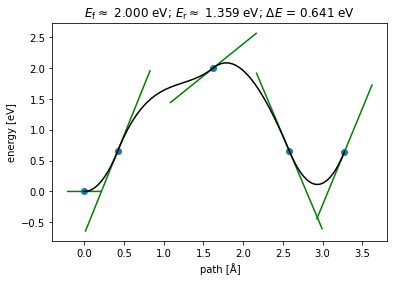

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9796          5.2203        2.3854     +  0.1397
      2          0.2220          1.8346        0.0876     +  0.1489


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0453          1.2444        0.0305     +  0.1590
      4          0.0235          0.9777        0.0185     +  0.2156
      5          0.0106          0.5560        0.0059     +  0.1854
      6          0.0067          0.3924        0.0030     +  0.2030
      7          0.0069          0.2903        0.0016     +  0.2016
      8          0.0061          0.2484        0.0012     +  0.2010
      9          0.0056          0.2195        0.0009     +  0.3091
     10          0.0051          0.1989        0.0008     +  0.4065
     11          0.0047          0.1885        0.0007     +  0.3030
     12          0.0046          0.1855        0.0007     +  0.0376
     13          0.0046          0.1855        0.0007     +  0.2064
     14          0.0023          0.1361        0.0004     +  0.1911
     15          0.0015          0.1216        0.0003     +  0.2110
     16          0.0020          0.1068        0.0002     +  0.4067
     17          0.0028          0.0961        0

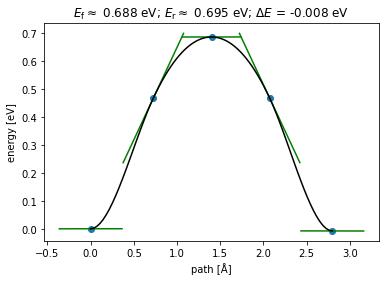

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.1042          4.7503        4.9997     +  0.1821


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3182          1.4633        0.1753     +  0.2395
      3          0.0806          1.1765        0.0580     +  0.2428
      4          0.0444          1.0131        0.0404     +  0.2466
      5          0.0459          0.5534        0.0135     +  0.3845
      6          0.0206          0.4580        0.0083     +  0.2607
      7          0.0117          0.3795        0.0055     +  0.2261
      8          0.0090          0.3254        0.0040     +  0.2355
      9          0.0073          0.2900        0.0032     +  0.2267
     10          0.0062          0.2687        0.0027     +  0.2341
     11          0.0056          0.2562        0.0025     +  0.2665
     12          0.0053          0.2515        0.0024     +  0.2276
     13          0.0053          0.2515        0.0024     +  0.2523
     14          0.0036          0.1654        0.0010     +  0.2932
     15          0.0048          0.1375        0.0007     +  0.3284
     16          0.0044          0.1243        0

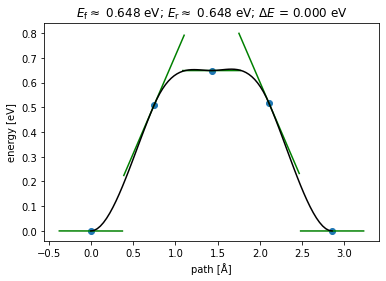

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7476          4.3950        6.1045     +  0.2170


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2453          1.1610        0.1820     +  0.2294
      3          0.0612          0.9605        0.0648     +  0.2522
      4          0.0365          0.7287        0.0360     +  0.5495
      5          0.0201          0.4444        0.0132     +  0.4010
      6          0.0105          0.3481        0.0079     +  0.2759
      7          0.0087          0.2946        0.0057     +  0.3479
      8          0.0081          0.2631        0.0045     +  0.2969
      9          0.0064          0.2342        0.0036     +  0.2744
     10          0.0044          0.2065        0.0028     +  0.2964
     11          0.0039          0.1949        0.0024     +  0.2719
     12          0.0038          0.1902        0.0023     +  0.2653
     13          0.0038          0.1902        0.0023     +  0.2621
     14          0.0048          0.1391        0.0013     +  0.3208
     15          0.0044          0.1255        0.0010     +  0.2708
     16          0.0033          0.1196        0

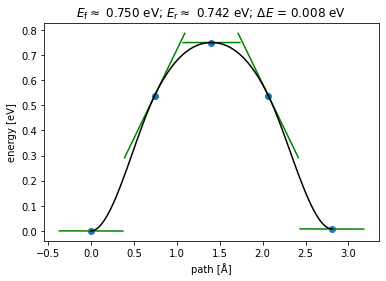

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6954          4.6603        9.3797     +  0.2528


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2068          1.0653        0.2210     +  0.3840
      3          0.0484          0.8310        0.0751     +  0.3119
      4          0.0236          0.6774        0.0474     +  0.3609
      5          0.0123          0.4270        0.0187     +  0.4379
      6          0.0082          0.3389        0.0117     +  0.3000
      7          0.0076          0.3006        0.0092     +  0.3244
      8          0.0080          0.2736        0.0077     +  0.3216
      9          0.0072          0.2413        0.0060     +  0.3019
     10          0.0062          0.2250        0.0052     +  0.3373
     11          0.0053          0.2115        0.0046     +  0.3016
     12          0.0050          0.2062        0.0043     +  0.2978
     13          0.0050          0.2062        0.0043     +  0.3024
     14          0.0051          0.1563        0.0025     +  0.3255
     15          0.0050          0.1304        0.0018     +  0.3133
     16          0.0042          0.1206        0

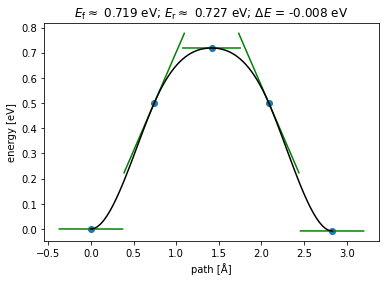

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.5246          4.5119       11.3555     +  0.2915


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2108          1.2117        0.3732     +  0.3029
      3          0.0405          0.9322        0.1317     +  0.3311
      4          0.0363          0.6531        0.0665     +  0.5754
      5          0.0173          0.4187        0.0264     +  0.4639
      6          0.0058          0.3279        0.0157     +  0.5438
      7          0.0029          0.2862        0.0119     +  0.4287
      8          0.0048          0.2537        0.0094     +  0.4242
      9          0.0051          0.2245        0.0074     +  0.3663
     10          0.0047          0.2094        0.0064     +  0.3580
     11          0.0044          0.2012        0.0059     +  0.3612
     12          0.0043          0.1984        0.0058     +  0.3569
     13          0.0043          0.1984        0.0058     +  0.3394
     14          0.0043          0.1513        0.0034     +  0.3447
     15          0.0033          0.1291        0.0025     +  0.3419
     16          0.0020          0.1162        0

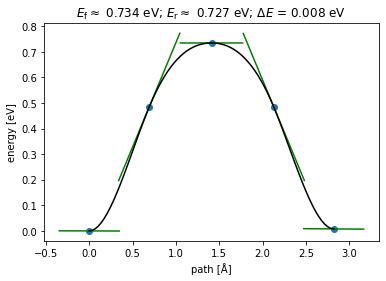

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.3981          4.3923       13.6139     +  0.3320


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1912          1.1638        0.4530     +  0.3632
      3          0.0377          0.8832        0.1629     +  0.3351
      4          0.0159          0.5683        0.0658     +  0.4203
      5          0.0088          0.3615        0.0265     +  0.3683
      6          0.0039          0.2935        0.0173     +  0.4230
      7          0.0047          0.2528        0.0129     +  0.3673
      8          0.0045          0.2083        0.0088     +  0.3986
      9          0.0040          0.1930        0.0075     +  0.3863
     10          0.0036          0.1839        0.0068     +  0.3629
     11          0.0035          0.1746        0.0061     +  0.3794
     12          0.0035          0.1701        0.0058     +  0.3679
     13          0.0035          0.1701        0.0058     +  0.4312
     14          0.0034          0.1359        0.0037     +  0.4426
     15          0.0037          0.1281        0.0033     +  0.4033
     16          0.0038          0.1182        0

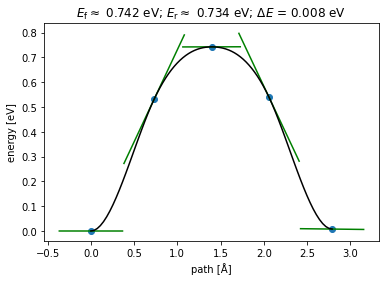

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4224          4.5272       18.5567     +  0.3936


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3822          1.4097        1.4723     +  0.4030
      3          0.0971          0.9267        0.2857     +  0.3839
      4          0.0132          0.6728        0.1193     +  0.3872
      5          0.0177          0.4446        0.0536     +  0.6436
      6          0.0136          0.3389        0.0312     +  0.7027
      7          0.0106          0.2964        0.0237     +  0.5733
      8          0.0089          0.2717        0.0198     +  0.4836
      9          0.0082          0.2489        0.0166     +  0.4838
     10          0.0077          0.2252        0.0136     +  0.4156
     11          0.0072          0.2129        0.0122     +  0.4707
     12          0.0071          0.2095        0.0118     +  0.5097
     13          0.0071          0.2095        0.0118     +  0.4313
     14          0.0031          0.1559        0.0064     +  0.5333
     15          0.0036          0.1448        0.0056     +  0.5064
     16          0.0052          0.1331        0

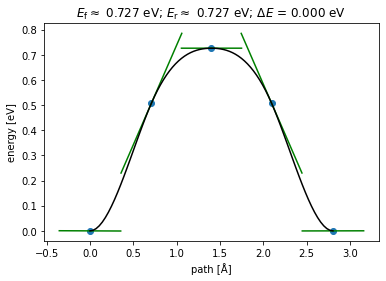

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.2183          4.2930       18.4517     +  0.3968


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2485          1.3005        1.0748     +  0.4133
      3          0.0493          0.8830        0.2793     +  0.4149
      4          0.0209          0.5383        0.0999     +  0.4312
      5          0.0102          0.3551        0.0428     +  0.5802
      6          0.0050          0.2908        0.0283     +  0.7000
      7          0.0039          0.2625        0.0230     +  0.4614
      8          0.0043          0.2415        0.0195     +  0.7504
      9          0.0040          0.2122        0.0151     +  0.5043
     10          0.0034          0.1929        0.0125     +  0.5112
     11          0.0032          0.1848        0.0114     +  0.4391
     12          0.0032          0.1825        0.0112     +  0.4577
     13          0.0032          0.1825        0.0112     +  0.4973
     14          0.0039          0.1471        0.0073     +  0.5276
     15          0.0047          0.1387        0.0066     +  0.4472
     16          0.0048          0.1288        0

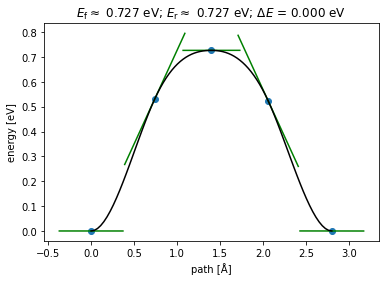

Terminating! Total number of iterations reached


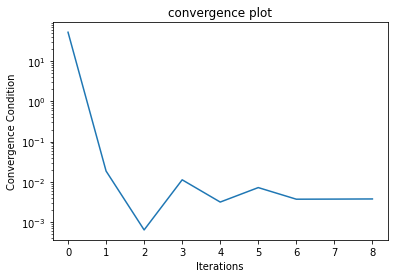

[52.58793232055905, 0.01854839465522673, 0.0006371068302541971, 0.011234699180931784, 0.003140996952424757, 0.007194652134785429, 0.0037005716731073335, 0.0037217965436866507, 0.0037533617578446865]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8943   650274.1875     +  0.1237
      2          0.0074          3.8999   652220.5000        0.1147


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0071          3.8751   643957.4375     +  0.1092
      4          0.0071          3.8450   633973.5625     +  0.1148
      5          0.0076          3.7947   617511.5625     +  0.1664
      6          0.0287          3.8987   652643.5000        0.1198
      7          0.0287          3.8986   652622.8125        0.1248
      8          0.0287          3.8986   652606.1875        0.1264
      9          0.0287          3.8986   652594.2500        0.1242
     10          0.0287          3.8985   652587.2500        0.1199
     11          0.0287          3.8985   652583.8125        0.0155
     12          0.0287          3.8985   652583.8125        0.0153
     13          0.0287          3.8985   652583.8125        0.1189
     14          0.0287          3.8984   652545.6875        0.1417
     15          0.0288          3.8983   652500.1250        0.1216
     16          0.0288          3.8981   652435.9375        0.1231
     17          0.0288          3.8973   652190

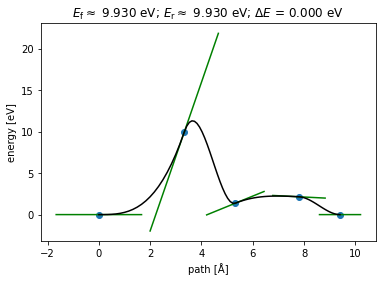

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0906          5.0011        2.4603     +  0.1354


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2555          1.5640        0.0747     +  0.1446
      3          0.0589          1.2773        0.0315     +  0.2373
      4          0.0511          1.0863        0.0228     +  0.2094
      5          0.0233          0.6338        0.0076     +  0.1863
      6          0.0067          0.4569        0.0038     +  0.1970
      7          0.0071          0.3236        0.0019     +  0.2625
      8          0.0068          0.2711        0.0014     +  0.2221
      9          0.0065          0.2434        0.0011     +  0.2001
     10          0.0061          0.2234        0.0009     +  0.1869
     11          0.0058          0.2135        0.0009     +  0.1933
     12          0.0057          0.2105        0.0008     +  0.0293
     13          0.0057          0.2105        0.0008     +  0.1902
     14          0.0025          0.1543        0.0004     +  0.1970
     15          0.0011          0.1332        0.0003     +  0.2026
     16          0.0018          0.1134        0

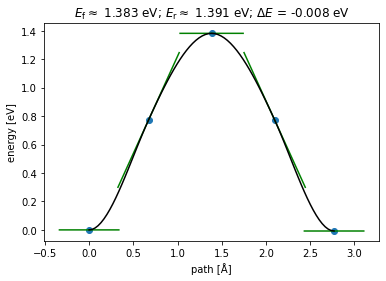

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.2361          5.0179        5.4767     +  0.1711


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3119          1.4773        0.1683     +  0.1887
      3          0.0723          1.1663        0.0544     +  0.2092
      4          0.0358          0.9009        0.0308     +  0.2101
      5          0.0250          0.4920        0.0094     +  0.2217
      6          0.0155          0.3609        0.0050     +  0.2319
      7          0.0096          0.3039        0.0035     +  0.2374
      8          0.0079          0.2766        0.0028     +  0.2289
      9          0.0069          0.2385        0.0021     +  0.5400
     10          0.0056          0.2070        0.0016     +  0.3416
     11          0.0052          0.1980        0.0015     +  0.3617
     12          0.0050          0.1942        0.0014     +  0.3324
     13          0.0050          0.1942        0.0014     +  0.2526
     14          0.0037          0.1469        0.0008     +  0.2333
     15          0.0040          0.1275        0.0006     +  0.2350
     16          0.0036          0.1087        0

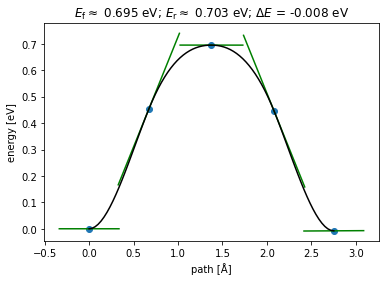

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8775          4.7420        6.9809     +  0.2084


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3162          1.4970        0.2992     +  0.2436
      3          0.0610          1.1058        0.0830     +  0.2874
      4          0.0368          0.8402        0.0467     +  0.4980
      5          0.0225          0.4636        0.0144     +  0.4619
      6          0.0092          0.3246        0.0068     +  0.3165
      7          0.0069          0.2824        0.0051     +  0.2669
      8          0.0064          0.2524        0.0041     +  0.2725
      9          0.0058          0.2227        0.0032     +  0.3370
     10          0.0051          0.1954        0.0025     +  0.2825
     11          0.0047          0.1815        0.0021     +  0.2655
     12          0.0047          0.1782        0.0020     +  0.2961
     13          0.0047          0.1782        0.0020     +  0.3139
     14          0.0034          0.1419        0.0013     +  0.3238
     15          0.0033          0.1340        0.0012     +  0.2813
     16          0.0035          0.1273        0

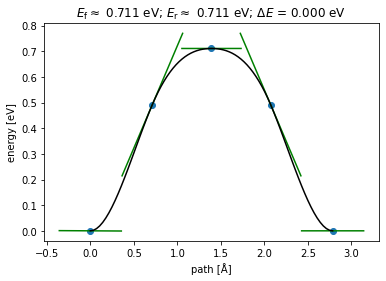

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6340          4.4436        8.5994     +  0.3078


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3076          1.3596        0.4190     +  0.2592
      3          0.0758          1.0159        0.1169     +  0.2721
      4          0.0373          0.7752        0.0632     +  0.2851
      5          0.0258          0.4430        0.0212     +  0.3560
      6          0.0151          0.3419        0.0122     +  0.3530
      7          0.0085          0.2964        0.0089     +  0.3119
      8          0.0056          0.2632        0.0070     +  0.3772
      9          0.0050          0.2337        0.0055     +  0.2939
     10          0.0049          0.2139        0.0046     +  0.2930
     11          0.0048          0.2040        0.0042     +  0.3045
     12          0.0048          0.2011        0.0041     +  0.3013
     13          0.0048          0.2011        0.0041     +  0.2966
     14          0.0037          0.1533        0.0024     +  0.3101
     15          0.0037          0.1431        0.0021     +  0.2968
     16          0.0039          0.1332        0

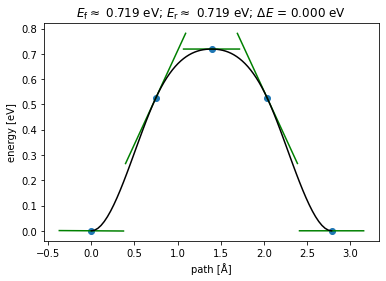

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.5354          4.4312       11.2983     +  0.4144


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2570          1.2120        0.4486     +  0.3375
      3          0.0538          0.8573        0.1161     +  0.3123
      4          0.0226          0.6295        0.0588     +  0.3411
      5          0.0134          0.3986        0.0235     +  0.3695
      6          0.0062          0.3007        0.0131     +  0.3721
      7          0.0057          0.2584        0.0097     +  0.4067
      8          0.0065          0.2324        0.0079     +  0.3618
      9          0.0063          0.2136        0.0067     +  0.3640
     10          0.0057          0.2001        0.0059     +  0.4176
     11          0.0052          0.1936        0.0055     +  0.4140
     12          0.0051          0.1917        0.0054     +  0.1742
     13          0.0051          0.1917        0.0054     +  0.3556
     14          0.0023          0.1545        0.0034     +  0.3387
     15          0.0027          0.1418        0.0029     +  0.3579
     16          0.0039          0.1322        0

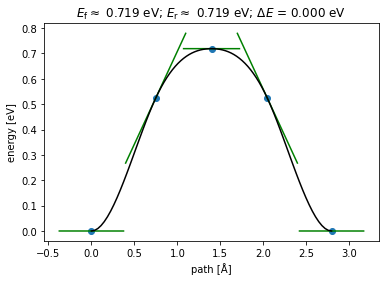

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4145          4.3998       13.4260     +  0.3238


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2753          1.2247        0.6571     +  0.3306
      3          0.0695          0.8784        0.1727     +  0.3466
      4          0.0217          0.6547        0.0852     +  0.4236
      5          0.0222          0.4016        0.0336     +  0.4440
      6          0.0125          0.3014        0.0183     +  0.4401
      7          0.0075          0.2575        0.0131     +  0.5072
      8          0.0057          0.2168        0.0093     +  0.5532
      9          0.0050          0.1890        0.0070     +  0.5445
     10          0.0045          0.1760        0.0061     +  0.4334
     11          0.0043          0.1704        0.0057     +  0.4760
     12          0.0042          0.1684        0.0056     +  0.3928
     13          0.0042          0.1684        0.0056     +  0.3863
     14          0.0035          0.1337        0.0035     +  0.3985
     15          0.0037          0.1280        0.0032     +  0.4556
     16          0.0040          0.1232        0

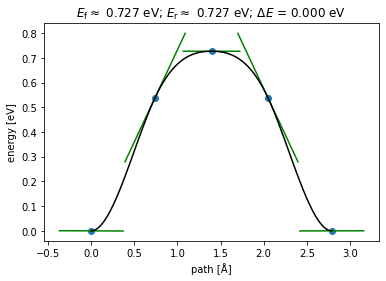

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.3860          4.3398       16.7449     +  0.3498


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2925          1.2913        0.9535     +  0.3867
      3          0.0647          0.8726        0.2169     +  0.4306
      4          0.0089          0.5671        0.0811     +  0.7218
      5          0.0133          0.3788        0.0371     +  0.5803
      6          0.0097          0.3085        0.0244     +  0.4928
      7          0.0087          0.2771        0.0197     +  0.4256
      8          0.0082          0.2501        0.0161     +  0.4288
      9          0.0074          0.2254        0.0131     +  0.4662
     10          0.0067          0.2121        0.0115     +  0.4305
     11          0.0063          0.2061        0.0109     +  0.4070
     12          0.0062          0.2042        0.0107     +  0.4573
     13          0.0062          0.2042        0.0107     +  0.4260
     14          0.0040          0.1637        0.0068     +  0.4064
     15          0.0035          0.1401        0.0050     +  0.4096
     16          0.0038          0.1322        0

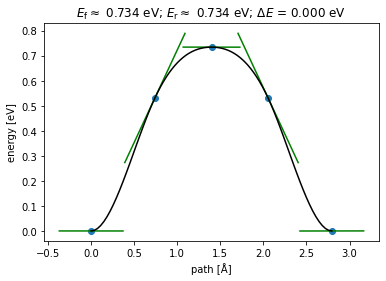

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.2641          4.3402       18.5232     +  0.3726


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2193          1.1781        0.8162     +  0.4605
      3          0.0468          0.8255        0.2320     +  0.4715
      4          0.0299          0.5544        0.1039     +  0.4402
      5          0.0216          0.3724        0.0474     +  0.4235
      6          0.0097          0.2951        0.0282     +  0.4556
      7          0.0067          0.2629        0.0221     +  0.4864
      8          0.0052          0.2353        0.0177     +  0.5271
      9          0.0049          0.1856        0.0110     +  0.4969
     10          0.0048          0.1638        0.0086     +  0.4983
     11          0.0047          0.1532        0.0076     +  0.4321
     12          0.0046          0.1505        0.0073     +  0.4471
     13          0.0046          0.1505        0.0073     +  0.4502
     14          0.0044          0.1091        0.0039     +  0.5078
     15          0.0044          0.1008        0.0034     +  0.5313
     16          0.0033          0.0859        0

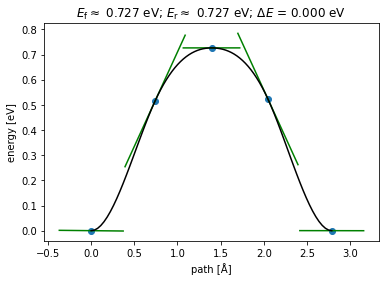

Terminating! Total number of iterations reached


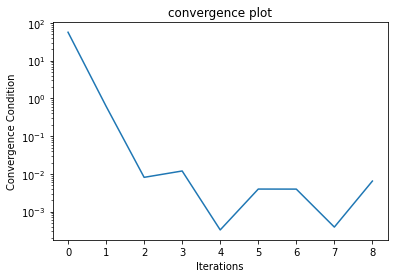

[56.80841433614842, 0.6212877121579368, 0.00809508103702683, 0.011931775399716571, 0.0003270942106610164, 0.003959272464271635, 0.003947923163650557, 0.00038886404945515096, 0.0064494683319935575]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9023   652975.3750     +  0.0951
      2          0.0022          3.8037   620370.7500     +  0.1163


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.3422          3.8989   777344.8750        0.1234
      4          0.1833          3.8989   687859.4375        0.1319
      5        143.7118          3.8989  22140239872.0000        0.1458
      6         63.3315          3.8989  4300217344.0000        0.1561
      7         38.1553          3.8989  1561263360.0000        0.1619
      8         24.2102          3.8989  628972224.0000        0.1537
      9         16.3324          3.8989  286598816.0000        0.1653
     10         13.3680          3.8989  192218512.0000        0.1581
     11         11.8176          3.8989  150358384.0000        0.1510
     12         11.8700          3.8989  151688688.0000        0.3358
     13         11.8697          3.8989  151682368.0000        0.4067
     14       2379.8787          3.8989  6071476813824.0000        0.4057
     15        858.6981          3.8989  790434676736.0000        0.3032
     16        369.5102          3.8989  146365710336.0000        0.1974
     17   

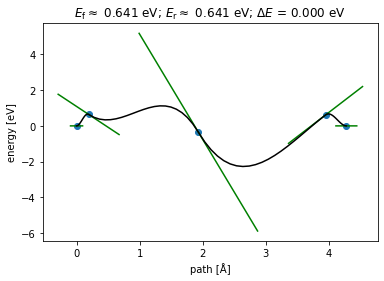

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9476          4.7427        2.1801     +  0.1811


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2201          1.7353        0.0785     +  0.1825
      3          0.0524          1.2586        0.0307     +  0.1697
      4          0.0533          1.0234        0.0208     +  0.1871
      5          0.0255          0.5584        0.0061     +  0.2026
      6          0.0085          0.3746        0.0026     +  0.1981
      7          0.0053          0.2977        0.0017     +  0.2219
      8          0.0050          0.2634        0.0013     +  0.1870
      9          0.0047          0.2428        0.0011     +  0.2611
     10          0.0042          0.2286        0.0010     +  0.2473
     11          0.0040          0.2216        0.0009     +  0.2842
     12          0.0039          0.2195        0.0009     +  0.0466
     13          0.0039          0.2195        0.0009     +  0.1949
     14          0.0018          0.1817        0.0006     +  0.1883
     15          0.0013          0.1620        0.0005     +  0.1932
     16          0.0027          0.1368        0

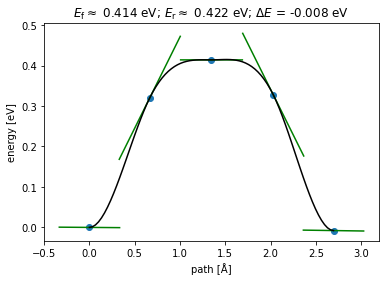

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0463          4.8342        4.5606     +  0.1768


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2516          1.3468        0.1210     +  0.2480
      3          0.0614          1.0786        0.0448     +  0.2531
      4          0.0475          0.9419        0.0336     +  0.2433
      5          0.0552          0.5712        0.0143     +  0.3011
      6          0.0271          0.4293        0.0072     +  0.2374
      7          0.0155          0.3411        0.0044     +  0.2425
      8          0.0094          0.3009        0.0033     +  0.2297
      9          0.0073          0.2773        0.0028     +  0.2327
     10          0.0064          0.2593        0.0024     +  0.2251
     11          0.0059          0.2468        0.0022     +  0.2264
     12          0.0057          0.2423        0.0021     +  0.4274
     13          0.0057          0.2423        0.0021     +  0.3671
     14          0.0027          0.1752        0.0011     +  0.4045
     15          0.0044          0.1579        0.0009     +  0.3050
     16          0.0060          0.1450        0

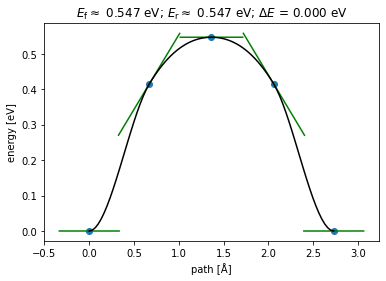

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0021          4.9233        7.7959     +  0.2175


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2828          1.3673        0.2424     +  0.2291
      3          0.0659          1.0704        0.0786     +  0.2372
      4          0.0387          0.8533        0.0480     +  0.2515
      5          0.0318          0.5512        0.0206     +  0.2644
      6          0.0216          0.4314        0.0124     +  0.3407
      7          0.0112          0.3640        0.0085     +  0.2687
      8          0.0079          0.3351        0.0071     +  0.4610
      9          0.0083          0.2968        0.0056     +  0.4814
     10          0.0084          0.2565        0.0042     +  0.4656
     11          0.0080          0.2425        0.0038     +  0.3018
     12          0.0078          0.2373        0.0036     +  0.2639
     13          0.0078          0.2373        0.0036     +  0.2712
     14          0.0038          0.1757        0.0020     +  0.2948
     15          0.0036          0.1664        0.0018     +  0.3527
     16          0.0041          0.1598        0

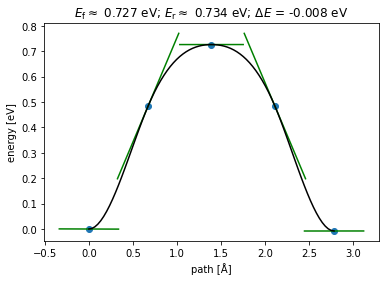

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6876          4.4465        9.0147     +  0.3044


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3363          1.4915        0.5006     +  0.3030
      3          0.0720          1.0660        0.1254     +  0.3250
      4          0.0340          0.7975        0.0659     +  0.2814
      5          0.0199          0.4633        0.0223     +  0.3049
      6          0.0103          0.3601        0.0131     +  0.3095
      7          0.0066          0.3178        0.0101     +  0.3020
      8          0.0080          0.2640        0.0071     +  0.3685
      9          0.0084          0.2294        0.0054     +  0.5233
     10          0.0078          0.2115        0.0046     +  0.4986
     11          0.0072          0.1969        0.0040     +  0.4167
     12          0.0068          0.1899        0.0037     +  0.3247
     13          0.0068          0.1899        0.0037     +  0.3031
     14          0.0049          0.1509        0.0023     +  0.3489
     15          0.0044          0.1397        0.0020     +  0.3027
     16          0.0049          0.1251        0

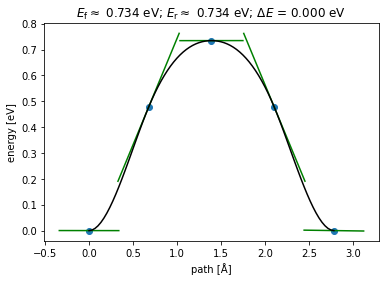

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4811          4.1892       10.1749     +  0.3186


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1869          1.0800        0.2867     +  0.3499
      3          0.0466          0.8259        0.1035     +  0.3379
      4          0.0331          0.5361        0.0442     +  0.3221
      5          0.0175          0.3914        0.0226     +  0.3418
      6          0.0108          0.3427        0.0169     +  0.7222
      7          0.0078          0.2960        0.0125     +  0.7130
      8          0.0065          0.2518        0.0091     +  0.3825
      9          0.0061          0.2224        0.0071     +  0.3513
     10          0.0059          0.2069        0.0061     +  0.4206
     11          0.0058          0.1998        0.0057     +  0.4258
     12          0.0057          0.1972        0.0056     +  0.3865
     13          0.0057          0.1972        0.0056     +  0.3933
     14          0.0047          0.1435        0.0030     +  0.4561
     15          0.0044          0.1310        0.0025     +  0.3382
     16          0.0041          0.1221        0

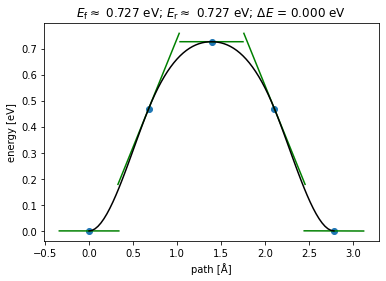

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.5022          4.4277       14.6340     +  0.3691


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1762          1.0199        0.3496     +  0.3418
      3          0.0432          0.7578        0.1195     +  0.3415
      4          0.0350          0.5283        0.0596     +  0.3654
      5          0.0209          0.3736        0.0290     +  0.3637
      6          0.0094          0.3152        0.0195     +  0.7415
      7          0.0063          0.2887        0.0162     +  0.5857
      8          0.0075          0.2364        0.0110     +  0.4141
      9          0.0067          0.2072        0.0085     +  0.4233
     10          0.0064          0.1964        0.0076     +  0.5208
     11          0.0060          0.1856        0.0068     +  0.3869
     12          0.0057          0.1787        0.0063     +  0.3882
     13          0.0057          0.1787        0.0063     +  0.4011
     14          0.0036          0.1409        0.0039     +  0.3705
     15          0.0038          0.1287        0.0033     +  0.4005
     16          0.0034          0.1180        0

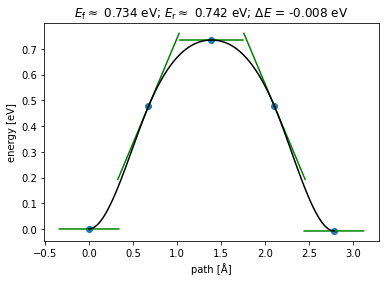

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.3194          4.3631       15.7957     +  0.4078


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2499          1.0537        0.6745     +  0.4757
      3          0.0720          0.7848        0.1882     +  0.3757
      4          0.0260          0.5507        0.0809     +  0.4295
      5          0.0208          0.4079        0.0447     +  0.5071
      6          0.0113          0.3355        0.0292     +  0.4392
      7          0.0077          0.3021        0.0234     +  0.4065
      8          0.0074          0.2797        0.0201     +  0.4134
      9          0.0074          0.2567        0.0170     +  0.4918
     10          0.0069          0.2313        0.0138     +  0.4217
     11          0.0064          0.2176        0.0122     +  0.4907
     12          0.0062          0.2144        0.0118     +  0.4037
     13          0.0062          0.2144        0.0118     +  0.4039
     14          0.0046          0.1761        0.0080     +  0.4094
     15          0.0044          0.1631        0.0068     +  0.3999
     16          0.0041          0.1545        0

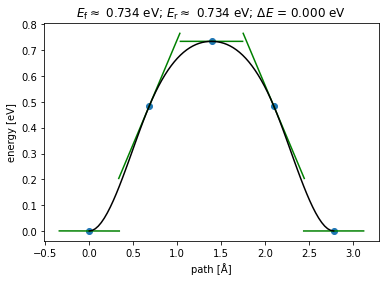

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.2580          4.3424       18.8396     +  0.4331


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2124          1.1932        0.8230     +  0.3983
      3          0.0411          0.8153        0.2280     +  0.4485
      4          0.0247          0.4963        0.0843     +  0.4172
      5          0.0143          0.3187        0.0344     +  0.4452
      6          0.0069          0.2585        0.0219     +  0.5382
      7          0.0063          0.2303        0.0174     +  0.4950
      8          0.0062          0.1874        0.0116     +  0.4923
      9          0.0056          0.1706        0.0096     +  0.4594
     10          0.0052          0.1604        0.0085     +  0.4506
     11          0.0050          0.1560        0.0081     +  0.5254
     12          0.0050          0.1547        0.0079     +  0.0615
     13          0.0050          0.1547        0.0079     +  0.4683
     14          0.0036          0.1308        0.0056     +  0.4746
     15          0.0034          0.1246        0.0051     +  0.4538
     16          0.0034          0.1181        0

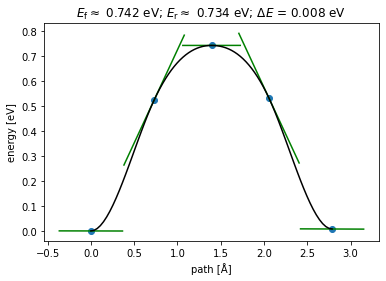

Terminating! Total number of iterations reached


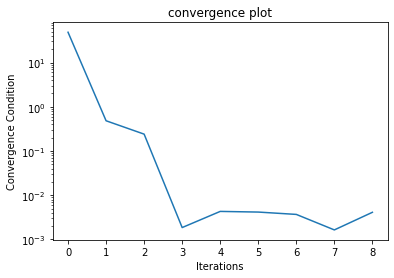

[48.526760338034364, 0.4829953903827118, 0.2407390661246609, 0.001857190451119095, 0.004306353686843067, 0.004161044882494025, 0.003682340044179, 0.001642465911572799, 0.004111384099815041]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8960   650859.7500     +  0.0476
      2          1.4876         27.7251  35332536.0000        0.0185
      3          1.4876         27.7251  35332536.0000        0.0150
      4          1.4876         27.7251  35332536.0000        0.0136
      5          1.4876         27.7251  35332536.0000        0.0120
      6          1.4876         27.7251  35332536.0000        0.0134
      7          1.4876         27.7251  35332536.0000        0.0130
      8          1.4876         27.7251  35332536.0000        0.0129
      9          1.4876         27.7251  35332536.0000        0.0129
 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


     12          1.4876         27.7251  35332536.0000        0.0150
     13          1.4876         27.7251  35332536.0000        0.0154
     14          1.4876         27.7251  35332536.0000        0.0129
     15          1.4876         27.7251  35332536.0000        0.0143
     16          1.4876         27.7251  35332536.0000        0.0154
     17          1.4876         27.7251  35332536.0000        0.0139
     18          1.4876         27.7251  35332536.0000        0.0132
     19          1.4876         27.7251  35332536.0000        0.0129
     20          1.4876         27.7251  35332536.0000        0.0118
     21          1.4876         27.7251  35332536.0000        0.0132
     22          1.4876         27.7251  35332536.0000        0.0126
     23          1.4876         27.7251  35332536.0000        0.0159
     24          1.4876         27.7251  35332536.0000        0.0114
     25          1.4876         27.7251  35332536.0000        0.0126
     26          1.4876         27

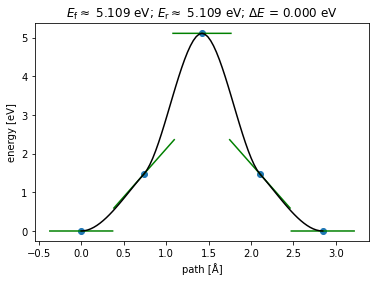

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9183          4.7208        2.1104     +  0.1634


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2327          1.5120        0.0672     +  0.1890
      3          0.0425          1.1203        0.0240     +  0.2045
      4          0.0464          0.9003        0.0160     +  0.2002
      5          0.0267          0.5812        0.0066     +  0.1949
      6          0.0115          0.4220        0.0033     +  0.1914
      7          0.0073          0.3537        0.0023     +  0.1982
      8          0.0069          0.3145        0.0018     +  0.2285
      9          0.0065          0.2852        0.0015     +  0.1942
     10          0.0064          0.2630        0.0013     +  0.3432
     11          0.0061          0.2494        0.0012     +  0.4414
     12          0.0059          0.2437        0.0011     +  0.3825
     13          0.0059          0.2436        0.0011     +  0.3538
     14          0.0029          0.1817        0.0006     +  0.2966
     15          0.0013          0.1701        0.0005     +  0.2239
     16          0.0028          0.1542        0

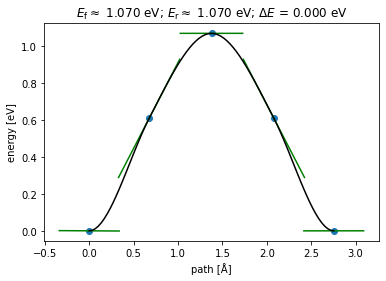

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8664          4.5006        3.9592     +  0.1903


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2504          1.4258        0.1328     +  0.1836
      3          0.0599          1.1402        0.0513     +  0.5081
      4          0.0491          0.9621        0.0364     +  0.3954
      5          0.0440          0.6216        0.0160     +  0.2863
      6          0.0270          0.4540        0.0083     +  0.3150
      7          0.0122          0.3424        0.0045     +  0.2754
      8          0.0074          0.3023        0.0034     +  0.2930
      9          0.0053          0.2758        0.0028     +  0.2959
     10          0.0042          0.2500        0.0023     +  0.3075
     11          0.0037          0.2317        0.0020     +  0.2995
     12          0.0035          0.2253        0.0019     +  0.2297
     13          0.0035          0.2253        0.0019     +  0.2622
     14          0.0029          0.1715        0.0011     +  0.2639
     15          0.0024          0.1527        0.0009     +  0.2311
     16          0.0023          0.1364        0

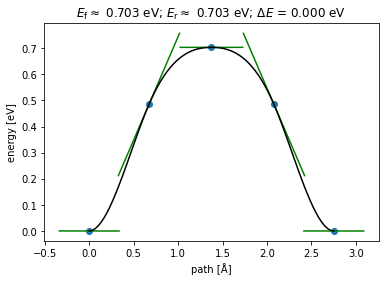

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7828          4.6715        6.6540     +  0.2996


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2642          1.4317        0.2493     +  0.2497
      3          0.0550          1.0858        0.0824     +  0.2725
      4          0.0357          0.7284        0.0369     +  0.2485
      5          0.0206          0.4120        0.0118     +  0.2559
      6          0.0132          0.3019        0.0063     +  0.2845
      7          0.0101          0.2660        0.0048     +  0.2934
      8          0.0081          0.2390        0.0039     +  0.2626
      9          0.0066          0.2142        0.0031     +  0.3349
     10          0.0056          0.1991        0.0027     +  0.2632
     11          0.0051          0.1929        0.0025     +  0.2644
     12          0.0050          0.1914        0.0024     +  0.0681
     13          0.0050          0.1914        0.0024     +  0.2715
     14          0.0030          0.1624        0.0017     +  0.2656
     15          0.0034          0.1423        0.0014     +  0.2726
     16          0.0037          0.1281        0

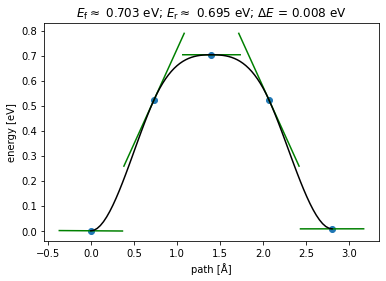

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4558          4.0606        7.1393     +  0.2535


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          1.3475          1.5899        4.9245     +  0.2669
      3          0.3317          1.3393        0.4670     +  0.2789
      4          0.0928          1.2595        0.1851     +  0.5130
      5          0.0194          1.1718        0.1421     +  0.5822
      6          0.0408          1.0159        0.1103     +  0.3901
      7          0.0391          0.6586        0.0485     +  0.3505
      8          0.0238          0.4501        0.0223     +  0.3302
      9          0.0147          0.3470        0.0129     +  0.3321
     10          0.0116          0.3082        0.0101     +  0.3673
     11          0.0105          0.2919        0.0090     +  0.3305
     12          0.0102          0.2874        0.0088     +  0.2975
     13          0.0102          0.2874        0.0088     +  0.3233
     14          0.0062          0.2082        0.0046     +  0.3645
     15          0.0064          0.1847        0.0036     +  0.3324
     16          0.0063          0.1548        0

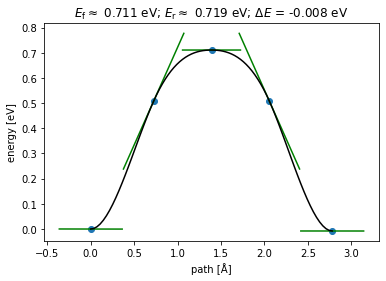

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6939          4.7778       13.9481     +  0.3355


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.4467          1.6069        1.1166     +  0.3538
      3          0.1071          1.0675        0.2104     +  0.3130
      4          0.0161          0.7623        0.0867     +  0.3207
      5          0.0215          0.4413        0.0304     +  0.3685
      6          0.0167          0.2991        0.0142     +  0.3476
      7          0.0112          0.2481        0.0095     +  0.3798
      8          0.0082          0.2190        0.0073     +  0.3702
      9          0.0064          0.1975        0.0059     +  0.3443
     10          0.0053          0.1819        0.0050     +  0.4570
     11          0.0047          0.1692        0.0043     +  0.3964
     12          0.0045          0.1643        0.0041     +  0.3421
     13          0.0045          0.1643        0.0041     +  0.3807
     14          0.0037          0.1238        0.0023     +  0.3288
     15          0.0034          0.1159        0.0020     +  0.3580
     16          0.0033          0.1099        0

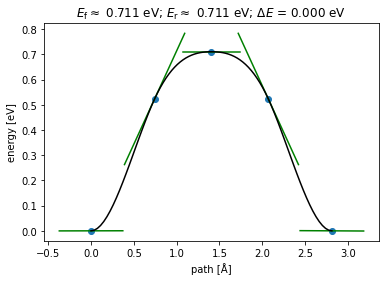

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4450          4.5198       14.4936     +  0.3490


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2755          1.3354        0.7344     +  0.3462
      3          0.0586          0.8793        0.1714     +  0.3575
      4          0.0316          0.5996        0.0767     +  0.3546
      5          0.0234          0.3523        0.0275     +  0.4054
      6          0.0116          0.2777        0.0161     +  0.3666
      7          0.0079          0.2502        0.0128     +  0.5544
      8          0.0070          0.2328        0.0111     +  0.4772
      9          0.0067          0.2028        0.0084     +  0.4382
     10          0.0060          0.1797        0.0066     +  0.3653
     11          0.0055          0.1672        0.0057     +  0.3792
     12          0.0054          0.1641        0.0055     +  0.4282
     13          0.0054          0.1641        0.0055     +  0.4423
     14          0.0039          0.1323        0.0036     +  0.3741
     15          0.0037          0.1281        0.0033     +  0.4291
     16          0.0034          0.1243        0

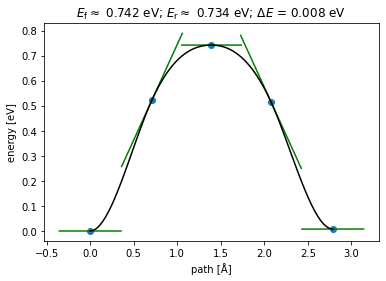

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.2610          4.1388       14.7478     +  0.3501


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2982          1.2124        0.9575     +  0.3758
      3          0.0709          0.8893        0.2377     +  0.3891
      4          0.0101          0.5756        0.0866     +  0.4020
      5          0.0145          0.3544        0.0339     +  0.4357
      6          0.0076          0.2813        0.0209     +  0.4025
      7          0.0060          0.2507        0.0165     +  0.4067
      8          0.0060          0.2223        0.0130     +  0.4133
      9          0.0062          0.1983        0.0104     +  0.5014
     10          0.0057          0.1839        0.0090     +  0.4108
     11          0.0053          0.1769        0.0083     +  0.4181
     12          0.0052          0.1738        0.0080     +  0.4538
     13          0.0052          0.1738        0.0080     +  0.4192
     14          0.0029          0.1318        0.0046     +  0.3960
     15          0.0031          0.1225        0.0040     +  0.4497
     16          0.0032          0.1177        0

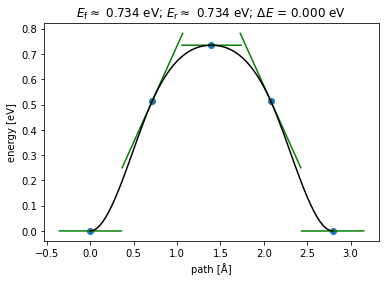

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.2955          4.3136       19.7624     +  0.4868


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1873          1.1700        0.7327     +  0.4686
      3          0.0330          0.8144        0.2253     +  0.4965
      4          0.0294          0.5242        0.0967     +  0.4199
      5          0.0173          0.3457        0.0414     +  0.4450
      6          0.0089          0.2810        0.0264     +  0.4515
      7          0.0075          0.2518        0.0211     +  0.4937
      8          0.0068          0.2295        0.0176     +  0.4499
      9          0.0063          0.1968        0.0130     +  0.4503
     10          0.0057          0.1790        0.0107     +  0.4421
     11          0.0051          0.1643        0.0090     +  0.4379
     12          0.0049          0.1589        0.0084     +  0.4860
     13          0.0049          0.1589        0.0084     +  0.5230
     14          0.0030          0.1194        0.0047     +  0.4882
     15          0.0030          0.1131        0.0042     +  0.4331
     16          0.0031          0.1083        0

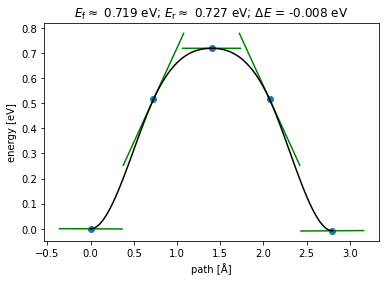

Terminating! Total number of iterations reached


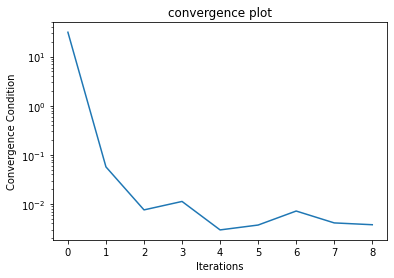

[31.48139365753741, 0.056832512957043946, 0.007558309021987952, 0.011232578835915774, 0.0029546256409958005, 0.0037149142008274794, 0.007166651092120446, 0.004105613144929521, 0.0037690082972403616]
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9066   654395.1875     +  0.1056
      2          0.0008          3.7881   615297.2500     +  0.1104


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0003          3.3561   482952.2188     +  0.1340
      4          0.0004          3.2383   449646.8750     +  0.1389
      5          0.0005          3.2218   445090.0938     +  0.1466
      6          0.0006          3.2100   441834.9062     +  0.1524
      7          0.0007          3.2071   441031.2812     +  0.1554
      8          0.0008          3.2053   440538.5625     +  0.1790
      9          0.0013          3.2006   439236.0000     +  0.1531
     10          0.0022          3.1905   436491.4062     +  0.1525
     11          0.0025          3.1854   435101.0938     +  0.1609
     12          0.0027          3.1835   434577.4688     +  0.0625
     13          0.0027          3.1835   434577.1875     +  0.1603
     14          0.0055          3.1550   426864.6562     +  0.1509
     15          0.0115          3.1299   420186.6250     +  0.1515
     16          0.0118          3.0714   404642.4375     +  0.1521
     17          0.0116          3.0025   386696

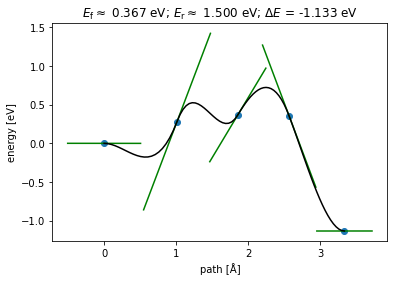

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8242          4.8638        2.3224     +  0.1374
      2          0.1914          1.6128        0.0765     +  0.1531


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0198          1.2172        0.0324     +  0.1883
      4          0.0262          0.7641        0.0131     +  0.3642
      5          0.0122          0.4749        0.0050     +  0.2870
      6          0.0077          0.3204        0.0023     +  0.1955
      7          0.0056          0.2339        0.0012     +  0.1976
      8          0.0054          0.1748        0.0007     +  0.2017
      9          0.0050          0.1442        0.0005     +  0.2002
     10          0.0048          0.1297        0.0004     +  0.2081
     11          0.0046          0.1227        0.0003     +  0.2736
     12          0.0046          0.1206        0.0003     +  0.0317
     13          0.0046          0.1206        0.0003     +  0.2111
     14          0.0029          0.0813        0.0001     +  0.2381
     15          0.0019          0.0712        0.0001     +  0.1956
     16          0.0012          0.0618        0.0001     +  0.1989
     17          0.0013          0.0531        0

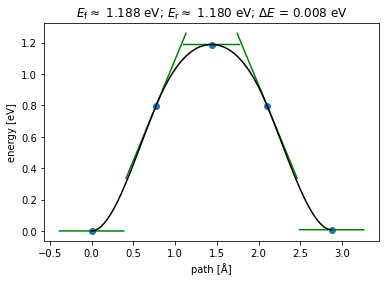

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9587          4.8899        4.8020     +  0.2237


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2747          1.3654        0.1503     +  0.2076
      3          0.0607          1.0217        0.0455     +  0.2331
      4          0.0191          0.8447        0.0290     +  0.2736
      5          0.0186          0.5503        0.0125     +  0.2316
      6          0.0117          0.3851        0.0061     +  0.2342
      7          0.0052          0.2935        0.0035     +  0.2461
      8          0.0039          0.2542        0.0026     +  0.2364
      9          0.0043          0.2159        0.0019     +  0.2347
     10          0.0044          0.1867        0.0014     +  0.2839
     11          0.0044          0.1734        0.0012     +  0.2399
     12          0.0044          0.1700        0.0012     +  0.0727
     13          0.0044          0.1700        0.0012     +  0.2344
     14          0.0040          0.1185        0.0006     +  0.3139
     15          0.0040          0.1066        0.0005     +  0.2998
     16          0.0037          0.0978        0

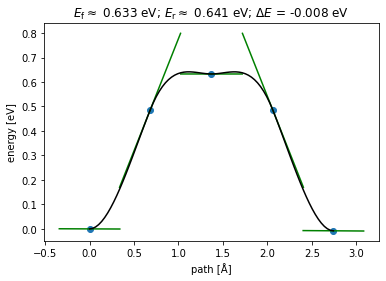

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6543          4.5070        6.3937     +  0.2046


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2418          1.2791        0.2232     +  0.2544
      3          0.0485          1.0001        0.0763     +  0.2384
      4          0.0369          0.7051        0.0383     +  0.2475
      5          0.0178          0.4129        0.0129     +  0.2681
      6          0.0080          0.3219        0.0076     +  0.2774
      7          0.0050          0.2675        0.0052     +  0.2587
      8          0.0055          0.2110        0.0033     +  0.2978
      9          0.0046          0.1782        0.0023     +  0.2842
     10          0.0039          0.1632        0.0019     +  0.2598
     11          0.0036          0.1562        0.0018     +  0.4196
     12          0.0035          0.1541        0.0017     +  0.0791
     13          0.0035          0.1541        0.0017     +  0.3462
     14          0.0028          0.1111        0.0009     +  0.3428
     15          0.0032          0.0991        0.0007     +  0.4608
     16          0.0035          0.0923        0

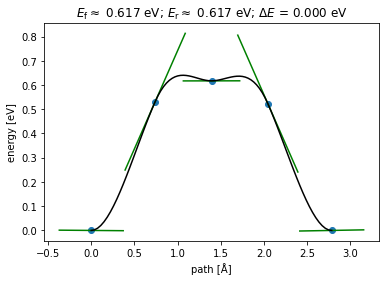

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.5182          4.3658        8.6700     +  0.2595


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2005          1.2112        0.2795     +  0.2919
      3          0.0321          0.9197        0.0986     +  0.2743
      4          0.0245          0.6179        0.0449     +  0.2888
      5          0.0092          0.3823        0.0168     +  0.2985
      6          0.0043          0.2900        0.0096     +  0.3054
      7          0.0064          0.2439        0.0068     +  0.4573
      8          0.0068          0.2118        0.0052     +  0.5479
      9          0.0062          0.1886        0.0041     +  0.4655
     10          0.0056          0.1754        0.0036     +  0.3810
     11          0.0054          0.1694        0.0033     +  0.3480
     12          0.0054          0.1675        0.0033     +  0.0816
     13          0.0054          0.1675        0.0033     +  0.3696
     14          0.0045          0.1318        0.0020     +  0.3299
     15          0.0045          0.1227        0.0018     +  0.3024
     16          0.0047          0.1140        0

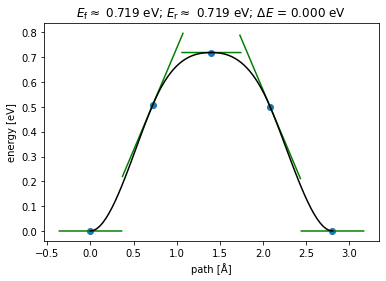

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.4907          4.6369       12.6181     +  0.4256


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1999          1.2807        0.4322     +  0.3100
      3          0.0319          0.8773        0.1302     +  0.3137
      4          0.0184          0.5279        0.0470     +  0.3448
      5          0.0130          0.3384        0.0194     +  0.4000
      6          0.0046          0.2623        0.0114     +  0.3368
      7          0.0034          0.2316        0.0088     +  0.3732
      8          0.0044          0.2084        0.0072     +  0.4259
      9          0.0048          0.1830        0.0056     +  0.3677
     10          0.0044          0.1640        0.0045     +  0.3268
     11          0.0042          0.1559        0.0041     +  0.3617
     12          0.0042          0.1534        0.0039     +  0.3862
     13          0.0042          0.1534        0.0039     +  0.3317
     14          0.0037          0.1154        0.0022     +  0.3920
     15          0.0036          0.1040        0.0018     +  0.4520
     16          0.0035          0.0959        0

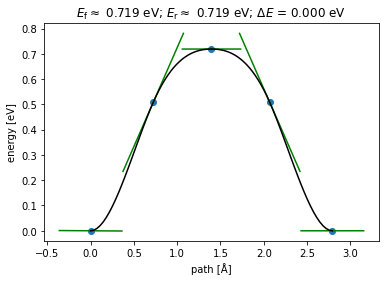

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.3279          4.3831       14.2239     +  0.3167


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2720          1.2371        0.7595     +  0.3480
      3          0.0644          0.8807        0.1976     +  0.3374
      4          0.0089          0.5519        0.0689     +  0.3455
      5          0.0113          0.3509        0.0284     +  0.4244
      6          0.0058          0.2665        0.0161     +  0.3821
      7          0.0052          0.2304        0.0121     +  0.4045
      8          0.0055          0.1999        0.0092     +  0.4386
      9          0.0050          0.1740        0.0069     +  0.6745
     10          0.0045          0.1605        0.0059     +  0.5271
     11          0.0045          0.1520        0.0053     +  0.4680
     12          0.0044          0.1483        0.0051     +  0.4100
     13          0.0044          0.1483        0.0051     +  0.3757
     14          0.0031          0.1138        0.0030     +  0.3840
     15          0.0029          0.1022        0.0024     +  0.3543
     16          0.0029          0.0954        0

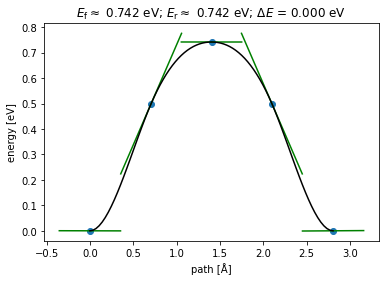

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.1894          4.2063       15.6402     +  0.3355


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2089          1.0426        0.6421     +  0.4148
      3          0.0480          0.7582        0.1864     +  0.3701
      4          0.0129          0.5128        0.0788     +  0.4744
      5          0.0123          0.3447        0.0361     +  0.4710
      6          0.0047          0.2745        0.0224     +  0.4099
      7          0.0052          0.2390        0.0170     +  0.4077
      8          0.0065          0.2116        0.0135     +  0.3924
      9          0.0059          0.1786        0.0097     +  0.3900
     10          0.0051          0.1614        0.0079     +  0.3908
     11          0.0048          0.1519        0.0070     +  0.4849
     12          0.0046          0.1483        0.0066     +  0.4051
     13          0.0046          0.1482        0.0066     +  0.4098
     14          0.0026          0.1049        0.0033     +  0.5550
     15          0.0025          0.0980        0.0029     +  0.4462
     16          0.0029          0.0926        0

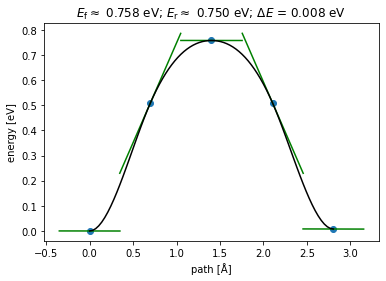

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.1144          4.1698       18.2739     +  0.4259


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.1935          0.9439        0.6893     +  0.3993
      3          0.0479          0.6494        0.1807     +  0.4494
      4          0.0107          0.4413        0.0746     +  0.5451
      5          0.0108          0.3345        0.0433     +  0.5003
      6          0.0059          0.2810        0.0301     +  0.4919
      7          0.0054          0.2469        0.0233     +  0.4366
      8          0.0054          0.2052        0.0162     +  0.4162
      9          0.0049          0.1751        0.0118     +  0.5131
     10          0.0043          0.1640        0.0103     +  0.4749
     11          0.0041          0.1565        0.0094     +  0.4345
     12          0.0041          0.1538        0.0091     +  0.4393
     13          0.0041          0.1538        0.0091     +  0.4857
     14          0.0029          0.1177        0.0053     +  0.5281
     15          0.0029          0.1097        0.0046     +  0.4827
     16          0.0030          0.1040        0

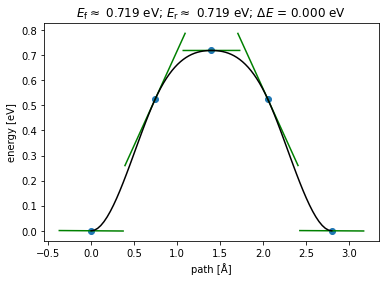

Terminating! Total number of iterations reached


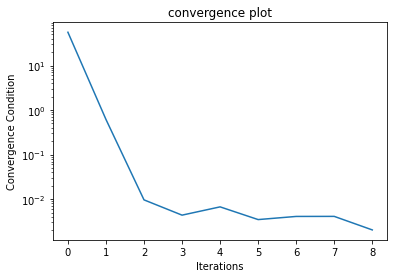

[55.9281982279208, 0.6168649374885717, 0.009633560403017327, 0.004373237126856111, 0.006709609180688858, 0.003477601785562001, 0.004091871393029578, 0.004103436236619018, 0.002037874044617638]


In [ ]:
force_calls = []
for i in range(5):
    #Here we run the code 5 times to ensure consistency of the results, for testing changing the 5 to a 1 is sufficient to run a full Active learning calculation to build the NEB
    # Define symmetry functions
    Gs = {}
    Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
    Gs["G2_rs_s"] = [0] * 4
    Gs["G4_etas"] = [0.005]
    Gs["G4_zetas"] = [1.0, 4.0]
    Gs["G4_gammas"] = [+1.0, -1]
    Gs["cutoff"] = 6.0

    # Training parameters for the active learning framework
    # For specific NEB query strategy, method must be neb_iter. For other query strategies do NOT use 
    # neb_iter, use iter or final
    training_params = {
        "al_convergence": {"method": "iter", "num_iterations": 7,'energy_tol':0.01,'convergence_check':False},
        "samples_to_retrain": 3,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 1,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 200,
        "test_split": 0,
        "shuffle": False,
        "verbose": 1,
        "filename": "neb_random_ml2relax_True",
        "file_dir": "./",
        "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}}
    }

    ml2relax = True #use machine learning to relax the initial and final states rather than DFT as is the norm

    parent_calc = Espresso(pw=500.0, 
                    calculation='scf',
                    kpts=(4,4,1),
                    xc='PBE')

    initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
    images = [initial]
    images.append(final)

    # Define AL scheme

    learner = AtomisticActiveLearner(
        training_data=images,
        training_params=training_params,
        parent_calc=parent_calc,
        convergence_func = 'neb_convergence',
        ensemble=False
    )

    # Learn the corresponding atomistic method
    total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

    learner.learn(
        atomistic_method=NEBcalc(
            starting_images=images, 
            ml2relax=ml2relax, 
            intermediate_samples=total_neb_images-2), 
        query_strategy=random_query
    )
    force_calls.append(initial_force_calls+learner.parent_calls)

In [ ]:
print('The DFT calls for each run of the active-learning framework is:',force_calls)

The DFT calls for each run of the active-learning framework is: [26, 26, 26, 26, 26]
